In [16]:
import sys
sys.path.append('/home/daniel/PycharmProjects/WageringSystem')

from Experiments.FundHistorySummary import FundHistorySummary
from numpy import cumsum
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def show_summary_grid(fund_history_summary: FundHistorySummary) -> None:
    sns.set(rc={'figure.figsize':(26,15)})
    f, axes = plt.subplots(2, 1)

    start_wealth = 500
    bet_limit_fraction = 0.33
    show_fixed_betting_wealth_progression(axes[0], fund_history_summary, start_wealth=start_wealth, betting_limit=100)
    show_dynamic_betting_wealth_progression(axes[1], fund_history_summary, start_wealth=start_wealth, bet_limit_fraction=bet_limit_fraction)

def show_fixed_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, betting_limit: float):
    snapshots = fund_history_summary.snapshots
    dates = [snapshot.date.split()[0] for snapshot in snapshots]
    absolute_payouts = [snapshot.payout_percentages * betting_limit for snapshot in snapshots]
    wealth_progression = [start_wealth + payout_sum for payout_sum in cumsum(absolute_payouts)]

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is: {betting_limit}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

def show_dynamic_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, bet_limit_fraction: float) -> None:
    dates = [snapshot.date.split()[0] for snapshot in fund_history_summary.snapshots]

    current_wealth = start_wealth
    wealth_progression = []
    for i in range(len(fund_history_summary.snapshots)):
        betting_limit = current_wealth * bet_limit_fraction
        current_wealth += fund_history_summary.snapshots[i].payout_percentages * betting_limit
        wealth_progression.append(current_wealth)

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is current wealth multiplied by {bet_limit_fraction:.2f}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

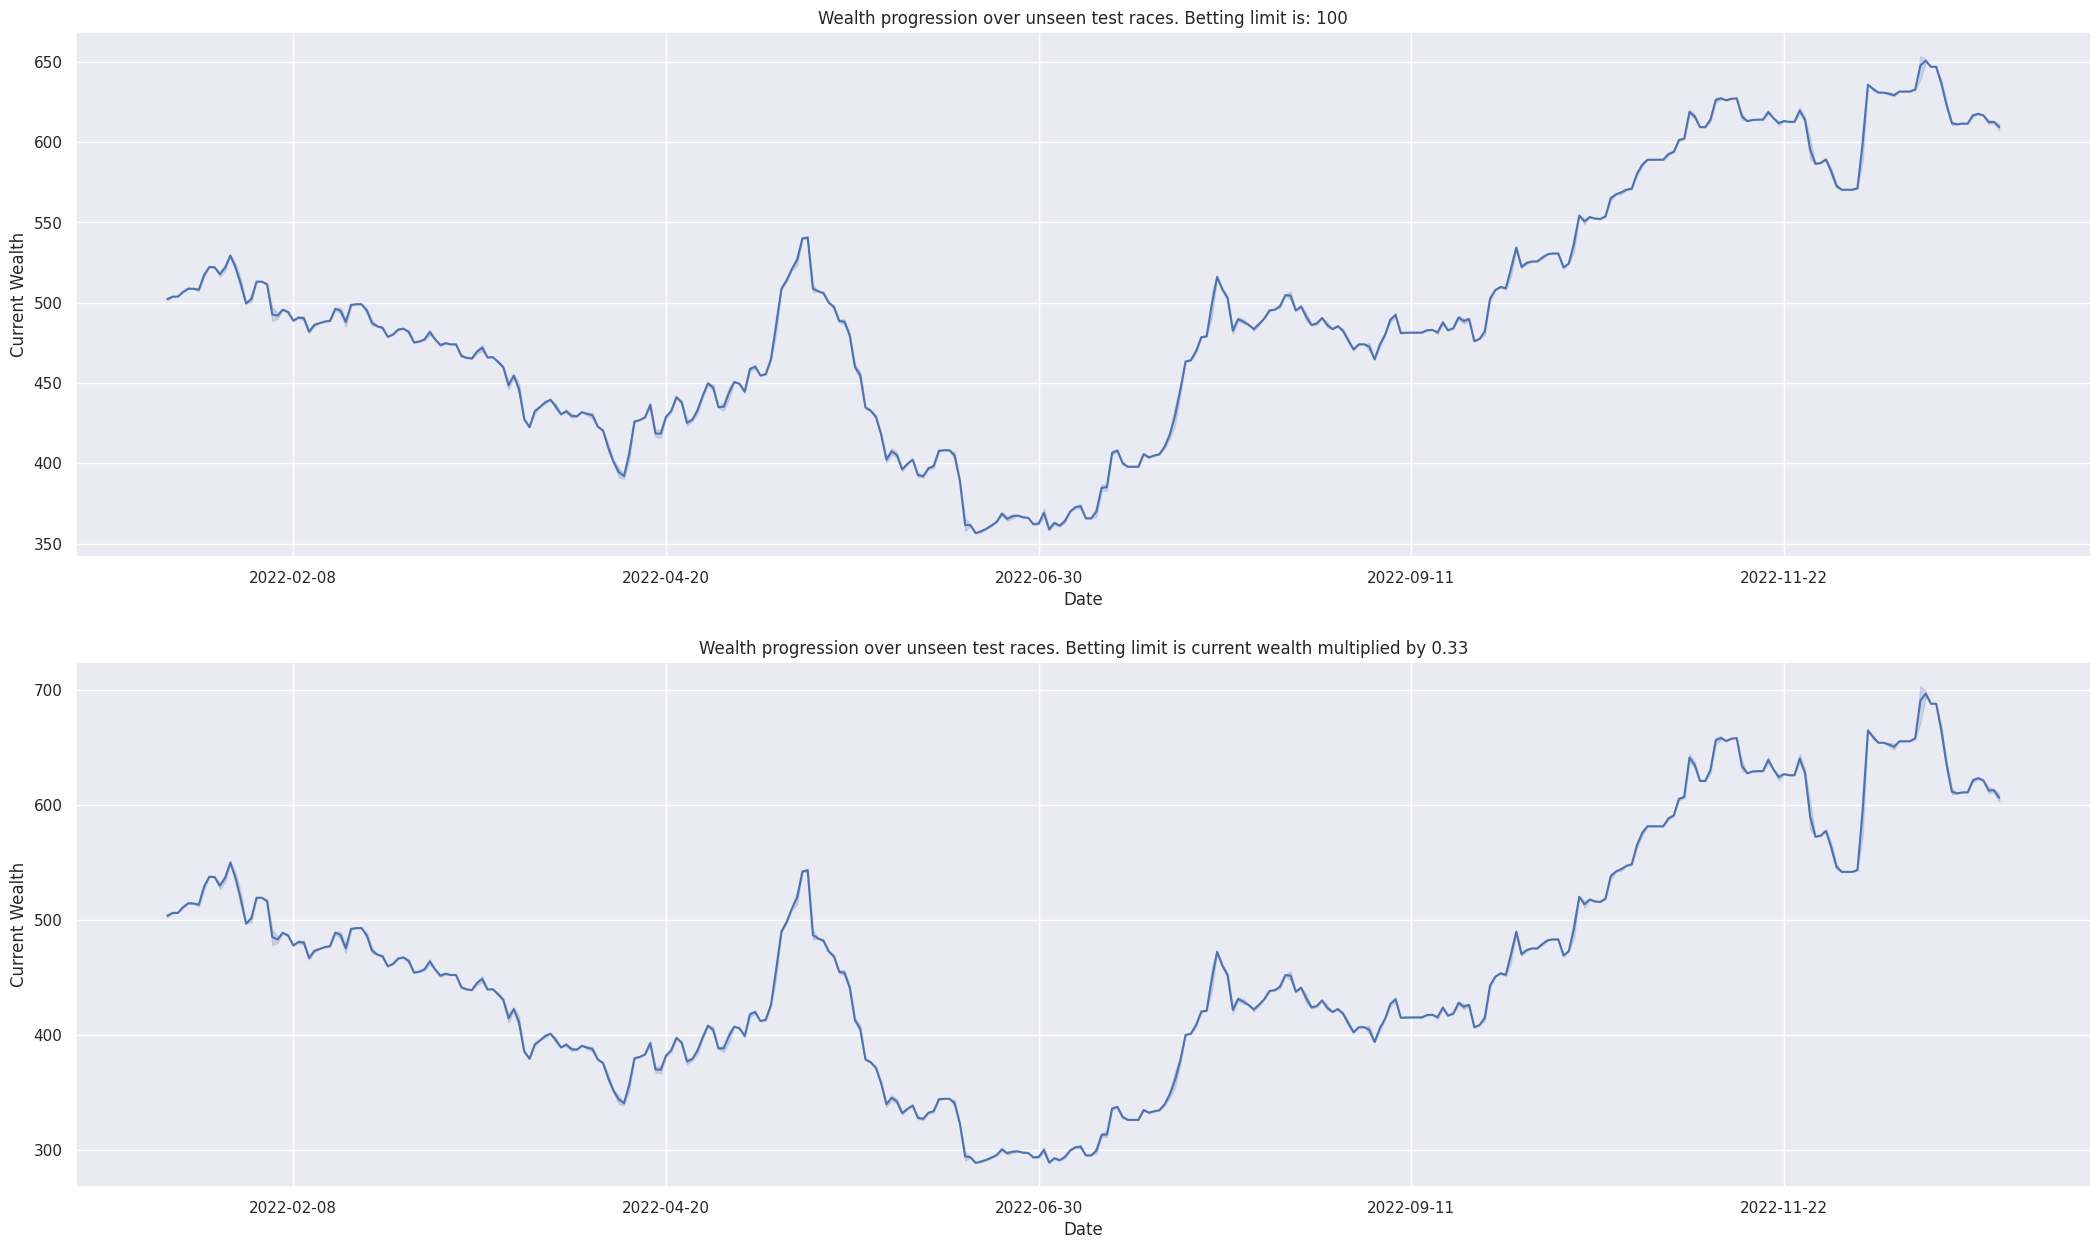

In [17]:
import pickle

FUND_HISTORY_SUMMARIES_PATH = "../data/fund_history_summaries.dat"

with open(FUND_HISTORY_SUMMARIES_PATH, "rb") as f:
    fund_history_summary = pickle.load(f)

show_summary_grid(fund_history_summary)

bet rate: 0.0531
max losses: 0.6346124544572952
min:-0.2657017336367798
max:0.4400298595343358
avg:0.00010522118248019448
Average winning odds: 2.475441176470588
{0: 0, 1: -0.08837979958301424, 2: -0.033839060546486256, 3: -0.1224527062321339, 4: -0.001102659163371448, 5: 0.2463250192397125, 6: 0.4400298595343358, 7: 0.009634278669678954, 8: 0.18558392636621807, 9: 0.05530952540318404, 10: 0.020984351234479073, 11: 0, 12: 0, 13: 0.012029933205098153, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}


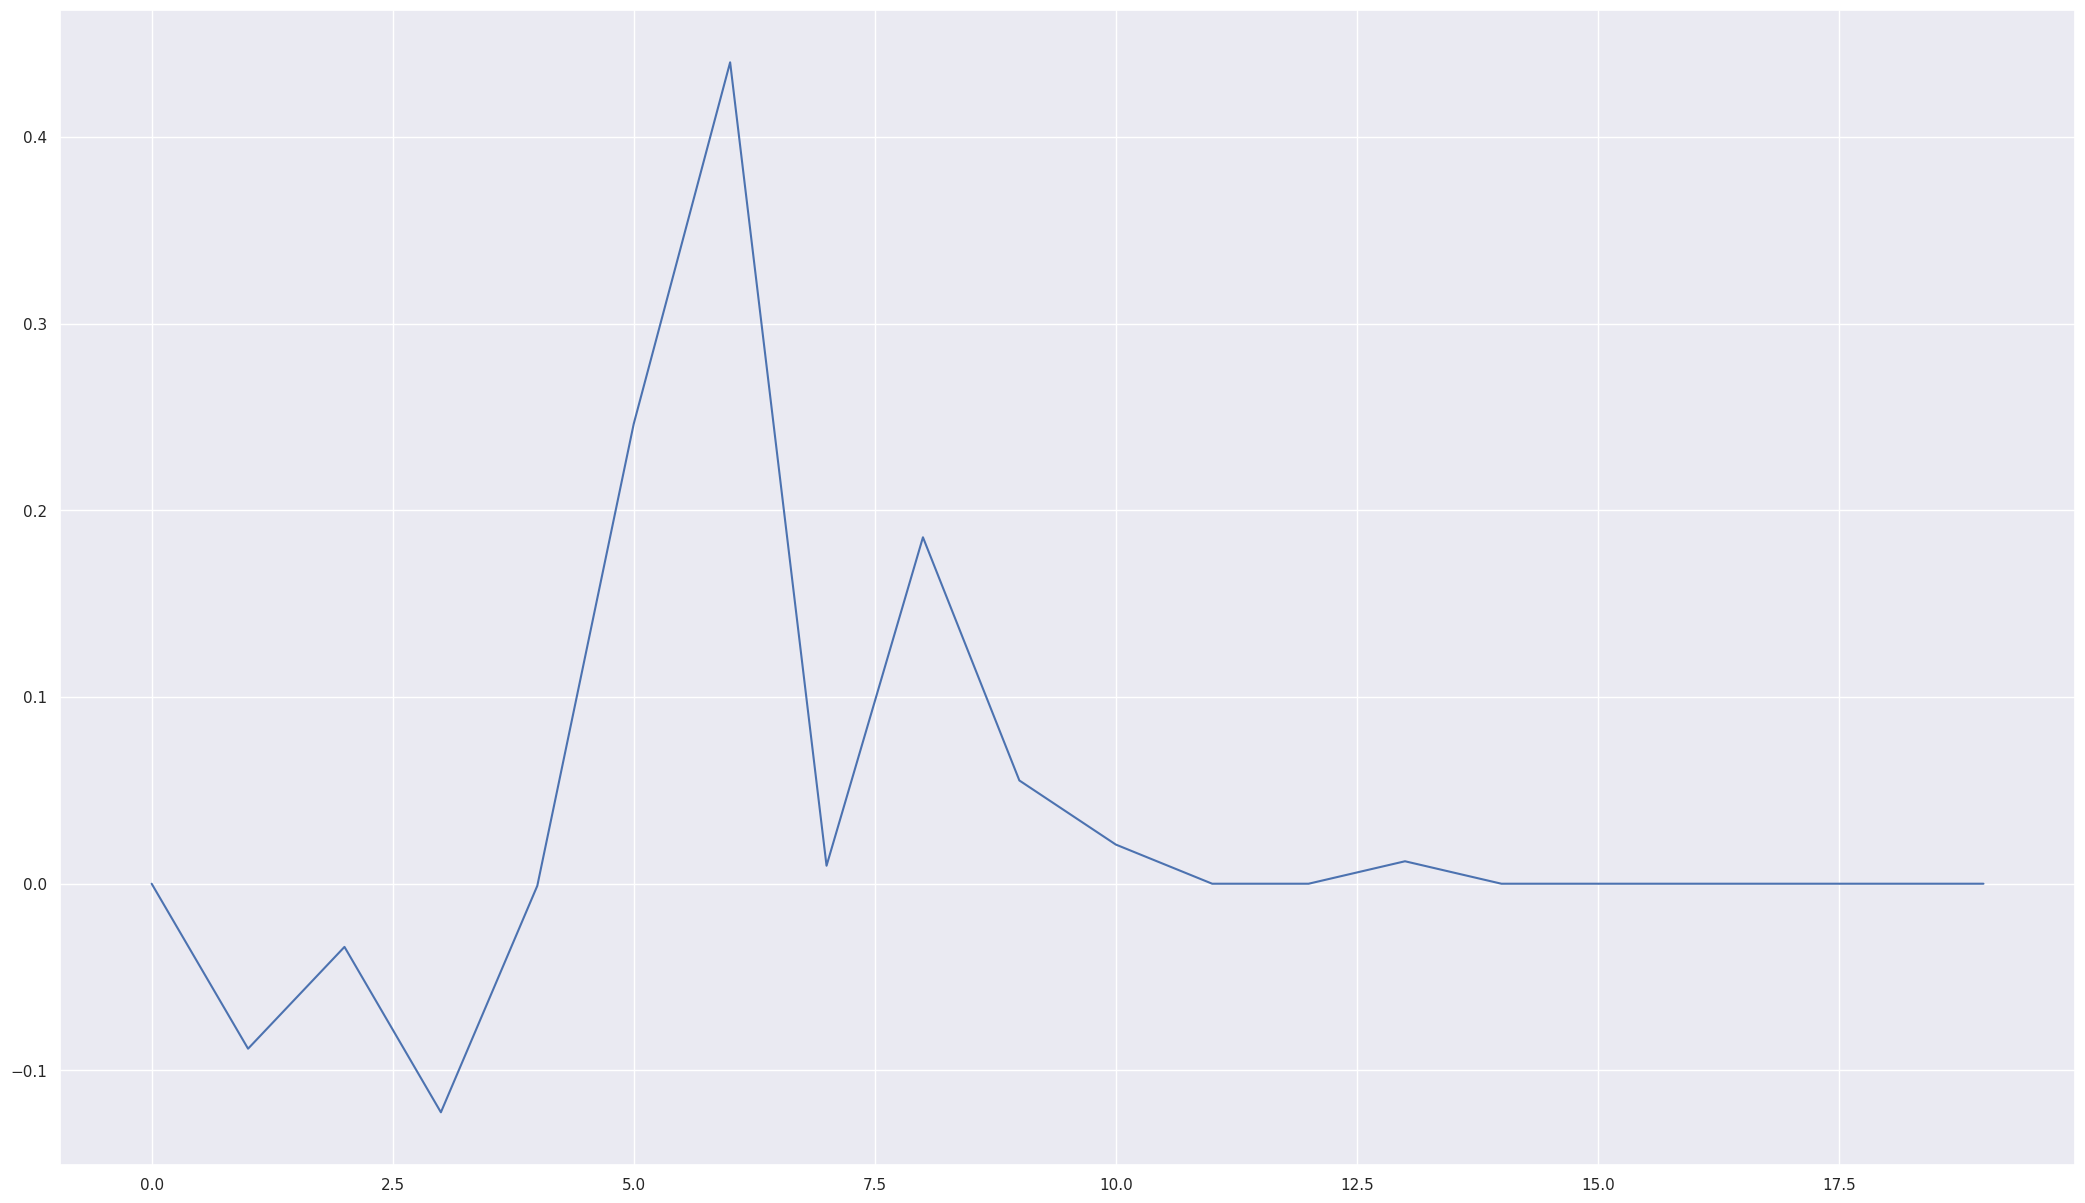

In [18]:
from numpy import average

losses = [betting_slip.loss for betting_slip in fund_history_summary.betting_slips.values()]
payouts = [betting_slip.payout_percentage for betting_slip in fund_history_summary.betting_slips.values()]

print(f"bet rate: {fund_history_summary.bet_rate}")
print(f"max losses: {max(losses)}")
print(f"min:{min(payouts)}")
print(f"max:{max(payouts)}")
print(f"avg:{average(payouts)}")

odds = []
n_bets = []
payout_bet_count_dist = {i: 0 for i in range(20)}
for betting_slip in fund_history_summary.betting_slips.values():
    odds += [bet.odds for bet in betting_slip.bets if bet.win > 0]
    payout_bet_count_dist[len(betting_slip.bets)] = betting_slip.payout_percentage
    if len(betting_slip.bets) >= 1:
        n_bets.append(str(len(betting_slip.bets)))

print(f"Average winning odds: {average(odds)}")
print(payout_bet_count_dist)
ax = sns.lineplot(data=payout_bet_count_dist)

## Real payout plotting

Text(0, 0.5, 'Wealth difference')

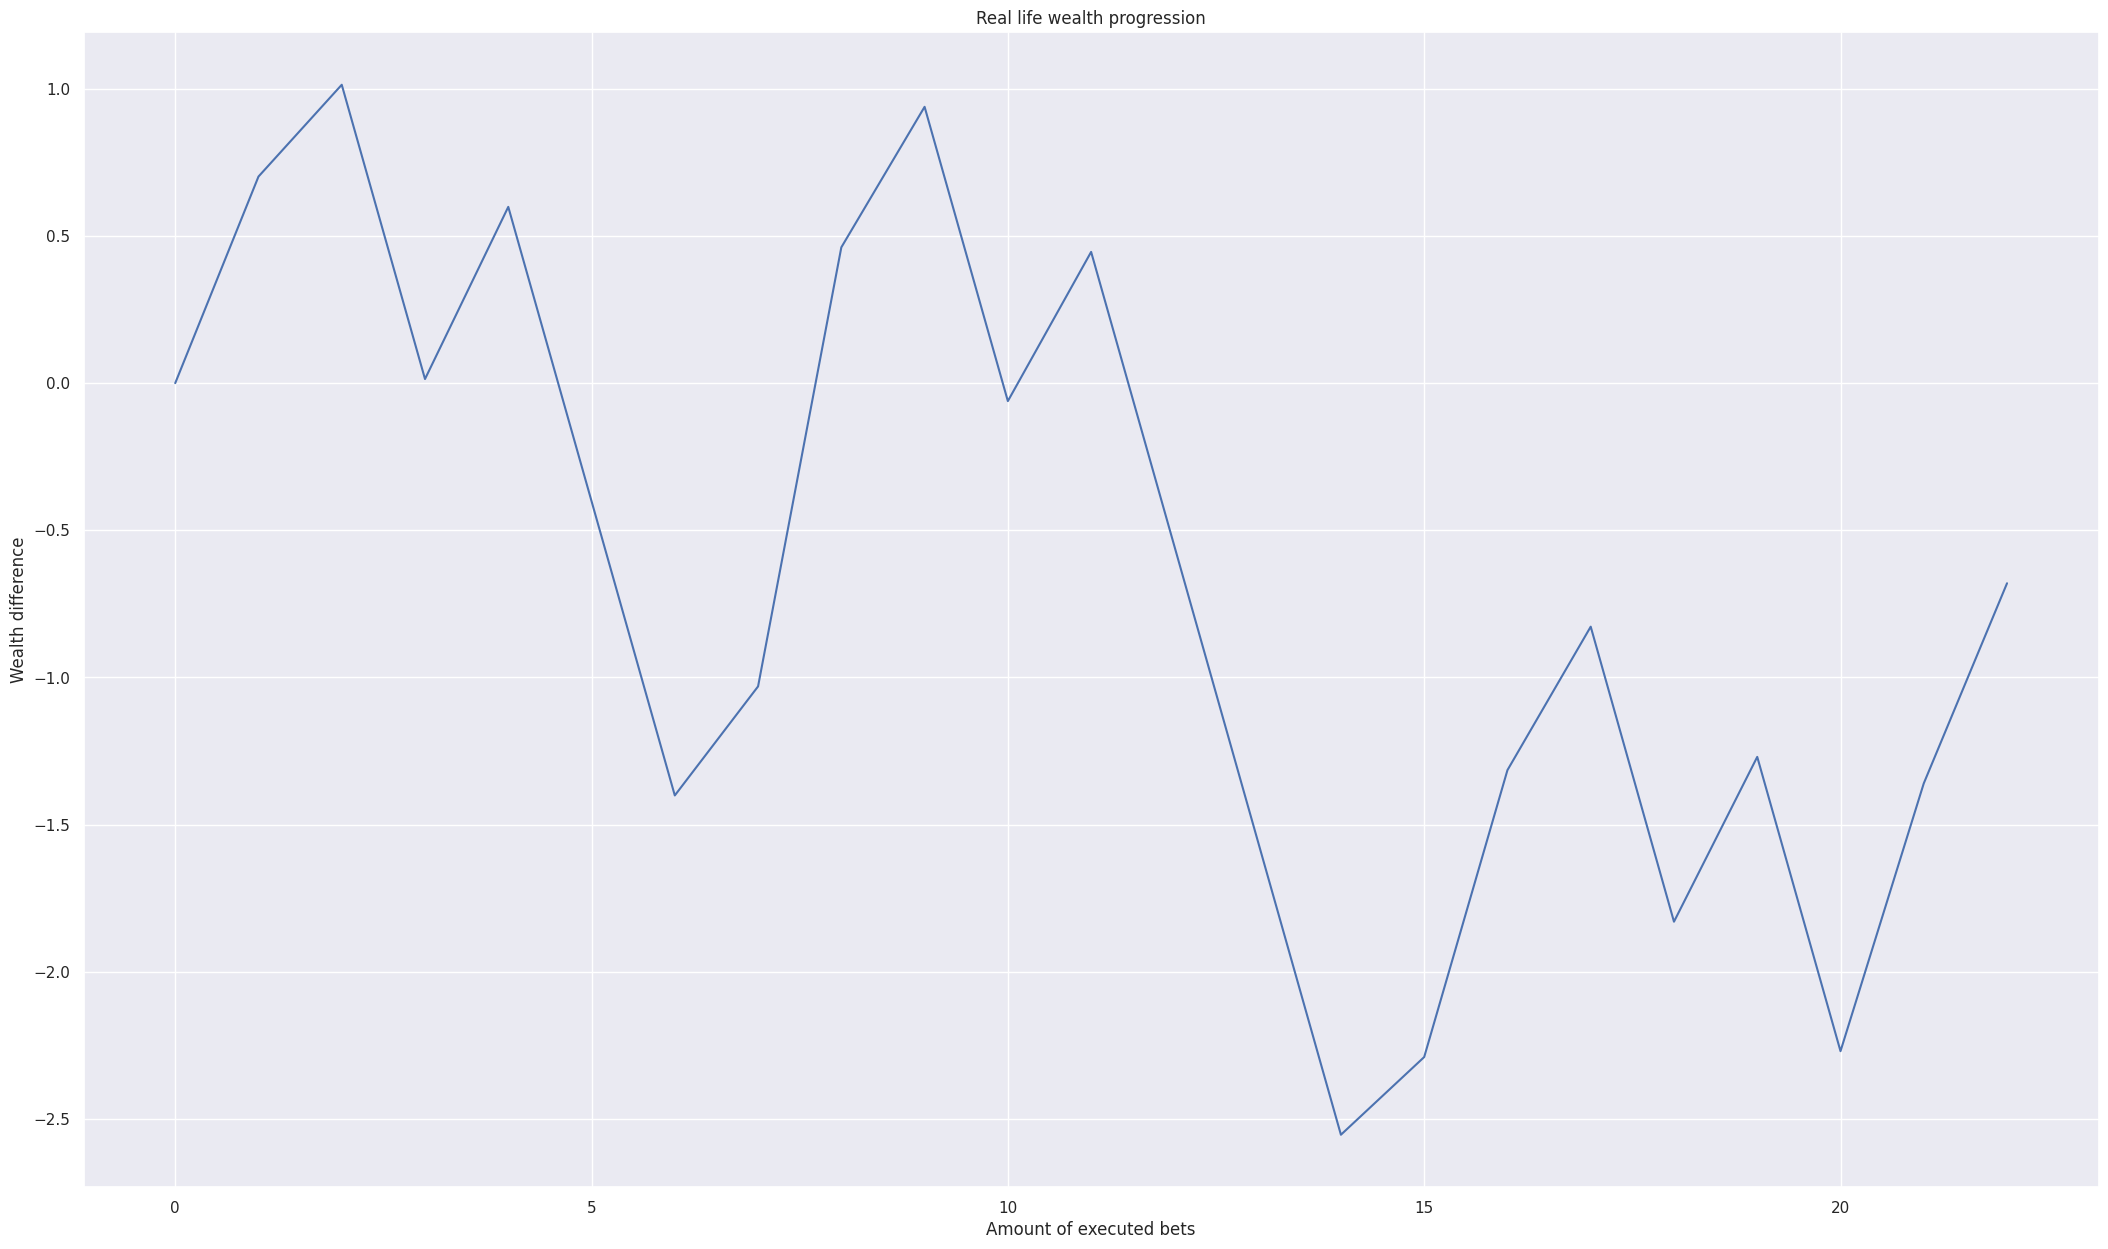

In [12]:
import seaborn as sns
real_payouts = [
    0,
    0.702,
    1.014,
    0.014,
    0.599,
    -0.401,
    -1.401,
    -1.0305,
    0.4615,
    0.939,
    -0.061,
    0.446,
    -0.554,
    -1.554,
    -2.554,
    -2.29,
    -1.315,
    -0.8275,
    -1.83,
    -1.27,
    -2.27,
    -1.36,
    -0.68,
]

ax = sns.lineplot(real_payouts)
ax.set_title("Real life wealth progression")
ax.set_xlabel("Amount of executed bets")
ax.set_ylabel("Wealth difference")

2.44359477124183